In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

%matplotlib inline


import warnings
warnings.filterwarnings('ignore')
# Exclude origin for brevity
training_columns = ['cylinders','displacement','horsepower','weight',
                    'acceleration','model_year']

df=pd.read_csv('heart.csv')
dataX=df.iloc[:,:-1]
datay=df.iloc[:,-1]
seed=8
X_train, X_test, y_train, y_test =train_test_split(dataX,datay,test_size=0.2,random_state=seed)

X = X_train
Y = y_train

training_columns=X_train.columns

## Grid search for best regularization

In [2]:

lr = LogisticRegression()
#alpha_values = np.array([0.25,0.5,1,2,4,8,16])
#param_grid = dict(alpha=alpha_values)
#kfold = KFold(n_splits=10, random_state=seed)
#grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
#grid_result = grid.fit(X, Y)

#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#grid_result = lr.fit(X, Y)
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

#lr = Ridge(**grid_result.best_params_)

lr = LogisticRegression()
kfold = KFold(n_splits=10, random_state=seed)
scores = cross_val_score(lr, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print('Raw ridge')

print(scores.mean())


Raw ridge
-0.1735



### Scale inputs

In [3]:
"""
scaled_lr = Pipeline([('Scaler', StandardScaler()),('LR', lr)])
scores = cross_val_score(scaled_lr, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print('Scaled ridge')
print(scores.mean())
cart_mean_error=scores.mean()
"""

"\nscaled_lr = Pipeline([('Scaler', StandardScaler()),('LR', lr)])\nscores = cross_val_score(scaled_lr, X, Y, cv=kfold, scoring='neg_mean_squared_error')\nprint('Scaled ridge')\nprint(scores.mean())\ncart_mean_error=scores.mean()\n"


**Evaluation results :
The cross-validated mean squared error for linear regression is approximately -0.18583 . This will be the baseline.**


### Linear model insights

In [4]:
"""
def print_coefs(coefs, training_columns):
    sorted_idx = np.argsort(-abs(coefs)) # negative for descending
    for (name, coef) in zip(np.array(training_columns)[sorted_idx], coefs[sorted_idx]):
        print("%s: %f" % (name, coef))

def plot_coefs(coefs, training_columns, title_suffix=''):
    sorted_idx = np.argsort(abs(coefs))
    pos = np.arange(len(coefs)) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, coefs[sorted_idx], align='center')
    plt.yticks(pos, np.array(training_columns)[sorted_idx])
    plt.xlabel('Coef value')
    plt.title('Coefficents' + title_suffix)
    plt.xlim(-5.5, 5.5)
    plt.show()

# use scaled model
lr.fit(X, Y)
print_coefs(lr.coef_, training_columns)
plot_coefs(lr.coef_, training_columns)

"""

'\ndef print_coefs(coefs, training_columns):\n    sorted_idx = np.argsort(-abs(coefs)) # negative for descending\n    for (name, coef) in zip(np.array(training_columns)[sorted_idx], coefs[sorted_idx]):\n        print("%s: %f" % (name, coef))\n\ndef plot_coefs(coefs, training_columns, title_suffix=\'\'):\n    sorted_idx = np.argsort(abs(coefs))\n    pos = np.arange(len(coefs)) + .5\n    plt.subplot(1, 2, 2)\n    plt.barh(pos, coefs[sorted_idx], align=\'center\')\n    plt.yticks(pos, np.array(training_columns)[sorted_idx])\n    plt.xlabel(\'Coef value\')\n    plt.title(\'Coefficents\' + title_suffix)\n    plt.xlim(-5.5, 5.5)\n    plt.show()\n\n# use scaled model\nlr.fit(X, Y)\nprint_coefs(lr.coef_, training_columns)\nplot_coefs(lr.coef_, training_columns)\n\n'


### Simple decision tree

In [5]:


from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

dt = DecisionTreeRegressor()

# Grid search meta parameters
param_grid = dict(min_samples_leaf=np.array([1,5,10,50,100,200]), max_depth=np.array([2,4,6,8,10]))
kfold = KFold(n_splits=10, random_state=seed)
grid = GridSearchCV(estimator=dt, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid_result = grid.fit(X, Y)

# Evaluate best model
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
dt = DecisionTreeRegressor(**grid_result.best_params_)
scores = cross_val_score(dt, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print('CART')
cart_mean_error=scores.mean()
print(scores.mean())

# Serialize tree structure for investigation
dt.fit(X, Y)
output_file = './auto_mpg.graphviz'
export_graphviz(dt, out_file=output_file, feature_names = X.columns)
print("Wrote output to " + output_file)


Best: -0.156712 using {'max_depth': 6, 'min_samples_leaf': 10}
CART
-0.15982791434990334
Wrote output to ./auto_mpg.graphviz


**Evaluation results:
The cross-validated mean squared error is for our CART tree is approximately -0.15898986807217172. This is worse than the linear model.**



### Gradient Boosting Trees


GBT
-0.14577162069822247


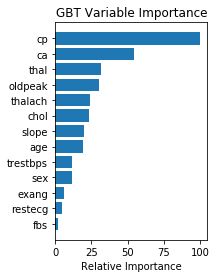

In [6]:

from sklearn.ensemble import GradientBoostingRegressor

scores = cross_val_score(GradientBoostingRegressor(), X, Y, cv=kfold, scoring='neg_mean_squared_error')
print('GBT')
print(scores.mean())

clf = GradientBoostingRegressor()
clf.fit(X, Y)

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

gb_mean_error=scores.mean()
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('GBT Variable Importance')
plt.show()


**Evaluation results and insights
The cross-validated mean squared error from GBT is approximately -0.14789370. This is better than the simple decision tree but worse than linear model**


### Logistic model tree

In [17]:
X.shape ,Y.shape

((303, 13), (303,))

In [18]:
import import_ipynb
import lmtmodel
from lmtmodel import LinearModelTree
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
 

shared_scaler = StandardScaler()
shared_scaler.fit(X)
X = dataX
Y = datay
def fit_linear_model(x, y):
    lr = LogisticRegression()
    lr.fit(shared_scaler.transform(x), y)
    return SharedScalerModel(shared_scaler, lr)

class SharedScalerModel:
    
    def __init__(self, scaler, lm):
        self.scaler = scaler
        self.lm = lm
        self.coef_ = lm.coef_
        self.intercept_ = lm.intercept_
        
    def predict(self, X):
        return self.lm.predict(self.scaler.transform(X))


MIN_NODE_SIZE =40
#best_score={}
#best_min_split_improvement=[0.003,0.01,0.05,0.1,0.2,0.5]

#for MIN_SPLIT_IMPROVEMENT in best_min_split_improvement :
MIN_SPLIT_IMPROVEMENT=0.1
lmt = LinearModelTree(MIN_NODE_SIZE, fit_linear_model, min_split_improvement=MIN_SPLIT_IMPROVEMENT)

kfold = KFold(n_splits=3, random_state=seed)
scores = []
for train_index, test_index in kfold.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index] 
    lmt.build_tree(X_train.values, X_train, y_train.values)
    y_pred = lmt.predict(X_test.values, X_test)
    mse = mean_squared_error(y_test, y_pred)
    scores.append(mse)
print(np.array(scores).mean())
#best_score

0.4488448844884489


### Build a tree on the full dataset, and serialize it to see the feature splits

In [19]:

lmt_1= LinearModelTree(MIN_NODE_SIZE, fit_linear_model, MIN_SPLIT_IMPROVEMENT)
lmt_1.build_tree(X.values,X, Y.values)

lmt_1.serialize()

7
152.0
not none
2
2.0
not none
4
237.0
not none
None
None
43 [-1.11084901  0.15123862 -0.33402519] [[ 2.34344693e-01 -6.04589865e-01  7.14662464e-01  1.18891729e-01
   8.95589851e-01 -1.28828738e-01  7.26007807e-02  8.37357152e-01
   4.23506267e-01 -5.74550137e-01 -9.90413671e-02 -4.47858751e-01
   5.06030663e-02]
 [-7.32251489e-04 -2.79656832e-01 -2.22305439e-01  1.43605246e-01
  -1.22355391e+00  3.47351020e-02 -2.44669343e-01 -5.58445920e-01
  -4.85637748e-01  3.36650242e-01 -3.81617478e-01 -7.91681070e-02
   2.95444386e-01]
 [-2.71325313e-01  7.04030281e-01  3.62429340e-01 -1.88909271e-01
   1.35930316e+00 -4.09047132e-02  1.10676911e-01  4.20733956e-01
   2.13810085e-01 -1.28300284e-02  6.14454689e-01  2.59920633e-01
  -3.47853386e-01]]


TypeError: only size-1 arrays can be converted to Python scalars

thalach
cp


(None, None)

In [ ]:
# the model split on 2 features : 

In [ ]:


root_lm = lmt.root.lm
node_1_coef = root_lm.coef_ + lmt.root.left.lm.coef_
plot_coefs(node_1_coef, training_columns, ' (horsepower < 78)')

right_coef = lmt.root.right.lm.coef_
node_2_coef = root_lm.coef_ + right_coef + lmt.root.right.left.lm.coef_
plot_coefs(node_2_coef, training_columns, ' (horsepower >= 78 & horsepower < 97)')


node_3_coef = root_lm.coef_ + right_coef + lmt.root.right.right.lm.coef_
plot_coefs(node_3_coef, training_columns, ' (horsepower >= 97)')


print_coefs(node_1_coef, training_columns)
print('')
print_coefs(node_2_coef, training_columns)
print('')
print_coefs(node_3_coef, training_columns)



displacement: -5.186292
model_year: 4.287827
weight: -4.287711
horsepower: -1.605432
cylinders: 0.685287
acceleration: 0.608814

weight: -5.522914
model_year: 2.410542
horsepower: -1.416881
acceleration: -0.805342
cylinders: -0.311572
displacement: -0.156405

weight: -2.154847
model_year: 1.428982
horsepower: -1.089580
displacement: 1.041145
cylinders: -0.867039
acceleration: -0.200428
In [430]:
rows = 1
cols = 3
coefs = [
    node_1_coef,
    node_2_coef,
    node_3_coef,
]
titles = ['Low power', 'Medium power', 'High power']
f, axs = plt.subplots(rows, cols, sharex='col', figsize=(12, 4))
for col in range(cols):
    pos = np.arange(len(coefs[col])) + .5
    axs[col].barh(pos, coefs[col], align='center')
    axs[col].set_yticks(pos)
    axs[col].set_yticklabels(np.array(training_columns))
    axs[col].set_xlabel('Coef value')
    axs[col].set_title(titles[col])
    axs[col].set_xlim(-5.5, 5.5)

f.tight_layout()

In [434]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

def gen(n=40):
    return np.random.normal(size=n)

rows, cols = 3, 5

fsize = 15

rownames = ['low power', 'medium power', 'high power']
subpop_data = [
    df.query('horsepower < 78'),
    df.query('horsepower >= 78 & horsepower < 97'),
    df.query('horsepower >= 97'),
]

cmap = sns.color_palette("Set2", cols)

f, axs = plt.subplots(rows, cols, sharex='col', figsize=(15, 6))

for i in range(rows):
    for j in range(cols):
        _ = axs[i,j].hist(subpop_data[i][training_columns[j]], histtype='step', color=cmap[j])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        left, right = _[1][0], _[1][-1]
        
        # black dots
        axs[i,j].scatter(left, 0, c='black', s=15)
        axs[i,j].scatter(right, 0, c='black', s=15)
        
        # min,max annotations
        axs[i,j].annotate(str(int(left)), 
                          xy=(left, 0), 
                          xytext=(-5, -20),
                          textcoords='offset points')
        
        axs[i,j].annotate(str(int(right)), 
                          xy=(right, 0), 
                          xytext=(-5, -20),
                          textcoords='offset points')
        
        if i == 0:
            axs[i,j].set_xlabel(training_columns[j], labelpad=15, size=fsize)
            axs[i,j].xaxis.set_label_position('top')
            
        if j == 0:
            axs[i,j].set_ylabel(rownames[i], size=fsize)

f.subplots_adjust(hspace=1.5)
sns.despine(left=True, bottom=True)
